# <center> Melting an icy moon </center>

<center>
    
    McGill Physics Hackathon 2023
    
    Jesse Sutherland and Susan Zhou
    
    Last edited: 2023-11-05
    
</center>





### Table of Contents:
1) [Equation for tidal heating](#1)
2) [Simplified model: melting one layer at a time](#2)
3) [Pushing model further: considering heat transfer between layers](#3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
G = 6.67430 * 10**(-11) # gravitational constant

## 1) Equation for tidal heating <a class="anchor" id="1">
    
Equation of heating rate due to tidal friction, found on [Wikipedia](https://en.wikipedia.org/wiki/Tidal_heating).

In [3]:
def E_flux_tidal (M_h, R, w, a, e, K):
    
    G = 6.67430 * 10**(-11)
    
    return K*(21/2)*(G*M_h**2*R**2*w*e**2)/a**6

In [4]:
# Sample values inspired from Europa (from wikipedia)

M_h = 1.8987*10**27 # Jupiter's mass, kg
R = 1560*10**3 # Europa radius, m
v_avg = 13743.36 # m/s
a = 670900*10**3 # average orbital radius, m
w = v_avg/a
e = 0.009
K = 0.02 
# "love number for frozen interior"
# Source: https://www.sciencedirect.com/science/article/pii/S0019103596956699?via%3Dihub
T_period = 3.551181*24*3600 # s

E_dot = E_flux_tidal(M_h, R, w, a, e, K) # in J/s


## 2) Simplified model: melting one layer at a time <a class="anchor" id="2">

Assumptions:
* Divide 100-km ice shell into 100 layers, and assume each layer is completely melted before the next layer begins to melt
* Assume material parameters (density, heat capacity, thermal conductivity) are constant

Change in temperature and heat are related by the heat capacity $C_p$ (J/K):

$$\Delta Q = C_p \Delta T$$

Since $\Delta Q = \dot{Q}\Delta t$, the time required to change the temperature of a substance by $\Delta T$ is:

$$ \Delta t = \frac{ \dot{Q}_\text{net}\Delta T} {C_p}$$

Assuming a melting point of 273 K, $\Delta T = 273 K - 100 K$.

### Materials parameters:

In [5]:
# Sources:
# https://www.engineeringtoolbox.com/ice-thermal-properties-d_576.html
# https://www.desmos.com/calculator/wicmrvrznj?lang=ru

def get_c_p(T):
    
    return 833 # J/kg.K (SI)

def get_k_t(T):
    return 3.48*10**3 # W/K

def get_rho(i):
    return 925.7 # kg/m3

In [6]:
# Simulation parameters

N = 100 # number of layers
R_ice_0 = 100 # m
delta_r = R_ice_0/N

R_body = 1000 # m


N = 100 # number of layers
R_ice_0 = 100*10**3 # m
delta_r = R_ice_0/N

R_body = 1450*10**3 # m


# Update arrays:

r_arr = np.arange(R_body, R_body+R_ice_0, delta_r)

A_sphere = 4*np.pi*r_arr**2 # dun increa that much

In [7]:
delta_t_layer = np.zeros(N)

for i in range(N):

    delta_t_layer[i] = get_c_p(0)*A_sphere[i]*delta_r*(273-100)/E_dot

    
delta_t_layer

total_t = delta_t_layer.copy()

for i in range(1, N):
    total_t[i] += total_t[i-1]

In [8]:
r_vs_t = np.zeros((2, N))
r_vs_t[0] = total_t
r_vs_t[1] = r_arr
np.savetxt('../data/r_vs_t.2.csv', r_vs_t.transpose(), delimiter=',')

Text(0, 0.5, 'Distance melted (m)')

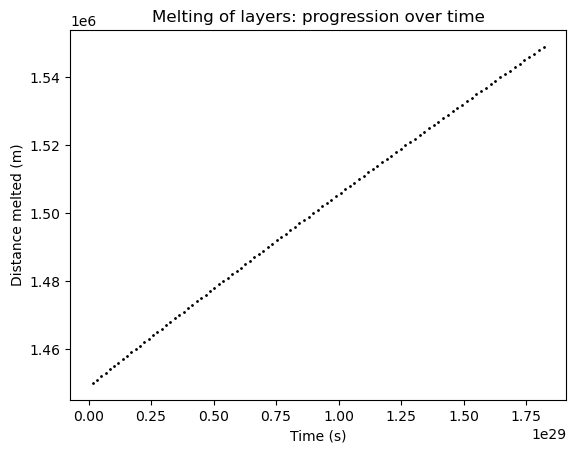

In [9]:
plt.scatter(total_t, r_arr, s=1, c="black")

plt.title("Melting of layers: progression over time")
plt.xlabel("Time (s)")
plt.ylabel("Distance melted (m)")

## 3) Pushing model further: considering heat transfer between layers <a class="anchor" id="3">

### Equations

1) Rate of heat transfer between two layers is computed with Fourier's law of heat conduction

$$ \dot{Q} = k_t A \frac{\Delta T}{\Delta r} $$

where $k_t$ is the thermal conductivity, $A$ is the contact area (surface of sphere), $\Delta T$ is the difference in temperature between the current layer and the previous layer, $\Delta r$ is the thickness of each layer. For each layer, the net rate of heat transfer $\dot{Q}_\text{net} = \dot{Q}_\text{in} - \dot{Q}_\text{out}$, where the heat flows from the hotter inner layers to the colder outer layers.


2) Change in temperature and heat are related by the heat capacity $C_p$ (J/K):

$$\Delta Q = C_p \Delta T$$

Since $\Delta Q = \dot{Q}\Delta t$, the change in temperature in a given time interval is:

$$ \Delta T = \frac{ \dot{Q}_\text{net}\Delta t} {C_p}$$

In [10]:
# Equations

def get_Q_dot(i):
    
    return get_k_t(i-1)*A_sphere[i]*(T_layer[i]-T_layer[i-1])/delta_r

def get_delta_T(i):
    
    return Net_Q_dot[i]*delta_t/(get_c_p(T_layer[i])*A_sphere[i]*delta_r*get_rho(0))


In [11]:
def get_Q_dot_2(i, A):
    
    
    return get_k_t(i-1)*A*(T_layer[i-1]-T_layer[i])/delta_r

def get_delta_T_2(Net_Q_dot, A):
    
    return Net_Q_dot*delta_t/(get_c_p(0)*A*delta_r*get_rho(0))

In [12]:
# Simulation 2


N = 100 # number of layers
R_ice_0 = 100 # m
delta_r = R_ice_0/N

R_body = 1000 # m


N = 100 # number of layers
R_ice_0 = 100*10**3 # m
delta_r = R_ice_0/N

R_body = 1450*10**3 # m



# Update arrays:

r_arr = np.arange(R_body, R_body+R_ice_0, delta_r)


T_layer = np.zeros(N)+100 # all start at 100 K

Net_Q_dot = np.zeros(N)

E_dot = E_flux_tidal(M_h, R, w, a, e, K)


delta_t = 10**3 # timescale


A_column = np.zeros(N)+1
A_sphere = 4*np.pi*r_arr**2 # dun increa that much


for t in range(30):

    Net_Q_dot[0] = E_dot - get_Q_dot(1)
    Net_Q_dot[N-1] = get_Q_dot(N-1)
    

    for i in range(1, N-1):

        Net_Q_dot[i] = get_Q_dot_2(i, 1) - get_Q_dot_2(i+1, 1)
        
        

    for i in range(N):
        T_layer[i] += get_delta_T_2(Net_Q_dot[i], 1)

In [13]:
np.savetxt('../data/T_distr.2.csv', T_layer, delimiter=',')

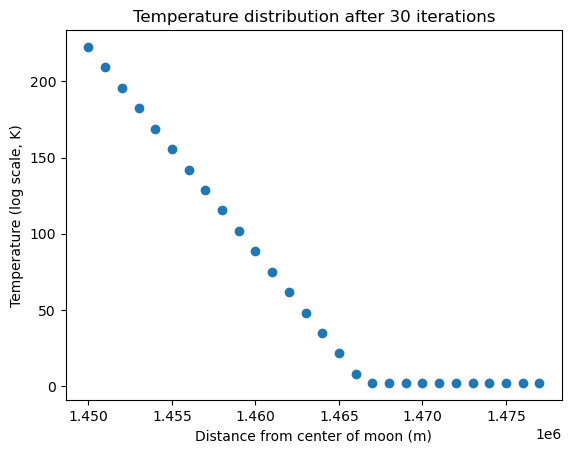

In [14]:
plt.scatter(r_arr[0:28], np.log10(T_layer[0:28]))

plt.title("Temperature distribution after 30 iterations")
plt.xlabel("Distance from center of moon (m)")
plt.ylabel("Temperature (log scale, K)")

plt.savefig('../figs/T_distr', dpi=150)